# Problem Statement

Aim of this exercise is to classify the websites based on their content. Here, we have got a dataset which contains list of websites, their kind and text extract from them.

Here, we would be using `Natural Language Processing(NLP)` techniques to develop out dataset and then create a Naive Bayes model based on it to classify websites.


## Methodology

1. Data exploring and understanding: This step involves preliminary level data understanding and exploring.

2. Data Cleaning: This step includes cleaning the existing data. We check the data for any missing values and treat them as per the requirements. We also need to look for constant value columns as that is not going to add any additional value to out analysis. Sometimes columns with very high proportion of any particular value also doesn't add any values. Hence, getting rid of them helps with further analysis.

3. Data Preparation: This step is mainly useful for feeding in the data into the model. It involves steps like creating dummy variables, scaling etc. depending upon the data type.  Here, we would be using `NLP` techniques to develop our dataset which can be fed to model.

4. Data Visualization: This step involves visualizing our dataset and check for relationship amongst independent variables. We can also reduce some feature columns here but it should not be aggressive.

5. Train-test split: This step involves splitting the dataset into train and test parts.

6. Model Development-validation and evaluation: This steps involves training the model and validate it. It involves evaluating the model using relevant metrics.

7. Conclusion/Recommendation: It involves drawing conclusions and recommendations to business.

### Importing Dependencies

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB

import nltk
#nltk.download()
from nltk.tokenize import word_tokenize

### Reading Dataset

In [2]:
data = pd.read_csv('website_classification.csv')
data.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


Dataset is having 4 columns including target variable `Category`.

## 1. Data exploring and understanding

In [3]:
data.shape

(1408, 4)

Data is having 1408 entries.
Here we have first column which indicates serial hence we would be dropping it.

In [4]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   website_url           1408 non-null   object
 1   cleaned_website_text  1408 non-null   object
 2   Category              1408 non-null   object
dtypes: object(3)
memory usage: 33.1+ KB


Dataset is not having any null entry hence we do not need to treat it for null values.

In [6]:
# website_url

data.website_url.nunique()

1384

It can be observed that `website_url` column is having 1384 unique entries. That means we have some duplicate entries in our dataset. We would be dropping those entries. 

## 2. Data Cleaning

In [7]:
# Dropping duplicate entries

data = data.drop_duplicates(subset='website_url').reset_index(drop=True)
data.shape

(1384, 3)

In [8]:
# Category

data.Category.value_counts(dropna=False)

Education                          114
Business/Corporate                 108
Travel                             107
Streaming Services                 104
E-Commerce                         101
Sports                             100
Games                               98
News                                94
Food                                92
Photography                         92
Computers and Technology            91
Health and Fitness                  88
Law and Government                  83
Social Networking and Messaging     80
Adult                               16
Forums                              16
Name: Category, dtype: int64

`Category` column is having 16 unique entries, which means this is a multi-class classification problem. Hence, we would be using `MultinomialNB` algorithm to solve it. MultinomialNB is efficient algorithm and can handle multi-class problems easily.

In [9]:
# cleaned_website_text

data.cleaned_website_text

0       official site good hotel accommodation big sav...
1       expedia hotel book sites like use vacation wor...
2       tripadvisor hotel book sites like previously d...
3       cheap flights search compare flights momondo f...
4       bot create free account create free account si...
                              ...                        
1379    old nude women porn mature granny sex horny ol...
1380    bdsm cams bdsm chat bondage cams free bdsm vid...
1381    porno dvd online european porn dvd cheap adult...
1382    anal dream house anal dream house anal dream h...
1383    world sex news daily sex news adult news eroti...
Name: cleaned_website_text, Length: 1384, dtype: object

`cleaned_website_text` column contains the content text from the website. We would be using this column to develop features for out model.

## 3. Data Preparation

#### Feature matrix development method:

We would extract words from `cleaned_website_text` columns and create an array of those words. Out of that array we would filter out english language stop_words which generally doesn't give any meaningful insight about the document. Out of the remaining words we would chose top `n` most recurring words and consider them as feature. 

Next part is to assign feature value to each of the data entry. For assigning feature value, we would use `TF-IFD` method.

`TF-IDF:` TF-IDF is a method of comparing how relevant a word is to any particular document (here website) from a given bunch of documents. 

$TF-IDF = TF(t,d)*IDF(t,D)$

where, 

TF(t,d) = (count of t in d)/(number of words in d)

$IDF(t,D) = log(D/(df + 1))$

$t$--> term of interest

$d$ --> document of interest

$D$ --> Set of documents

$df$ --> occurrence of t in documents

To summarize, TF-IDF score of any feature for any particular document would be high if that feature term occurs rarely in other documents and/or percentage occurrence for that term in the given document is higher.


Additional Reading Source: 
https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

Before developing TF-IDF based array we need to filter out words with `Parts Of Speech (POS)` other than `NOUN`. The logic behind it is that `NOUN` gives better representation of website content as compared to other `POS`.

Here we would be using `NLTK` library to tokenize the corpus from each website and assign `POS` tag to each word. Then we would filter in only `NOUN` tagged words and reverse convert them into corpus. The filtered words corpus would be meaningless for us but can enhance the performance of our model.

In [10]:
# filtering noun words from corpus

filtered_words = []
for i in range(data.shape[0]):
    tagged = nltk.pos_tag(word_tokenize(data.cleaned_website_text[i]), tagset='universal')
    filtered_words.append(' '.join([word_tag[0] for word_tag in tagged if word_tag[1]=='NOUN']))

In [11]:
# adding filtered_words to our dataframe

data['filtered_words'] = filtered_words
data.head()

,website_url,cleaned_website_text,Category,filtered_words
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,site hotel accommodation hotel destination hot...
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,hotel book sites use vacation work year day da...
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,hotel book sites bar review year tripadvisor h...
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,flights search flights flight momondo airline ...
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,bot account account sign sign account ebooker ...


Let's develop TF-IDF based array using `filtered_words` column from out dataset. Here we have selected some hyperparameters as per following.

- min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. We would use 5 as min frequency.

- stop_words: We would remove English stopwords if at all they are present in the filtered words. Stopwords adds no meaning to the model.

- max_features: Maximum features to be included the the data. We are going to use 1500 features. 

Note: Naive Bayes algorithm can easily handle larger number of features as compared to data size.

In [12]:
# Vectorized form of tfidf 

tfidf = TfidfVectorizer(sublinear_tf=True,
                        min_df=5,
                        stop_words = 'english',
                        max_features = 1500)
feat = tfidf.fit_transform(data.filtered_words)

In [13]:
# feature/term names

tfidf.get_feature_names()

['ability',
 'academy',
 'access',
 'accessibility',
 'accessories',
 'accessory',
 'accommodation',
 'accord',
 'account',
 'act',
 'action',
 'activity',
 'ad',
 'add',
 'addition',
 'address',
 'administration',
 'adult',
 'advance',
 'advantage',
 'adventure',
 'advertise',
 'advertisement',
 'advertising',
 'advice',
 'affairs',
 'affiliate',
 'africa',
 'age',
 'agency',
 'agent',
 'agreement',
 'aid',
 'aim',
 'air',
 'aircraft',
 'airport',
 'al',
 'algebra',
 'amazon',
 'america',
 'americans',
 'analysis',
 'angeles',
 'animation',
 'announce',
 'announcement',
 'answer',
 'app',
 'apple',
 'application',
 'applications',
 'appointment',
 'approach',
 'apr',
 'april',
 'architecture',
 'area',
 'arrest',
 'art',
 'article',
 'articles',
 'artist',
 'arts',
 'asia',
 'ask',
 'ass',
 'assessment',
 'asset',
 'assistance',
 'association',
 'aston',
 'attack',
 'attention',
 'audience',
 'audio',
 'aug',
 'august',
 'australia',
 'author',
 'authority',
 'auto',
 'availability',


In [14]:
# Converting tfidfvector to dataframe

X = pd.DataFrame(feat.toarray(), columns = tfidf.get_feature_names())
X.head()

,ability,academy,access,accessibility,accessories,accessory,accommodation,accord,account,act,...,yang,year,yesterday,yoga,york,youth,youtube,zealand,zone,zoom
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.151736,0.0,0.099145,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.043593,0.0,0.0,0.0,0.157710,0.0,0.000000,0.0,...,0.0,0.067354,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.249193,0.0,0.000000,0.0,...,0.0,0.106424,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.136153,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.084154,0.0,0.179314,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [15]:
# checking range for values in X

X.describe()

,ability,academy,access,accessibility,accessories,accessory,accommodation,accord,account,act,...,yang,year,yesterday,yoga,york,youth,youtube,zealand,zone,zoom
count,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,...,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000
mean,0.003751,0.002325,0.014417,0.006712,0.005891,0.005041,0.003351,0.003338,0.015643,0.007311,...,0.001147,0.023518,0.002591,0.004644,0.007907,0.003334,0.009917,0.004911,0.002574,0.002117
std,0.019566,0.015880,0.034770,0.023616,0.031538,0.027073,0.021150,0.015411,0.039898,0.029461,...,0.018016,0.034580,0.019955,0.035586,0.027381,0.020309,0.030436,0.024940,0.018244,0.016080
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.045992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.272661,0.209302,0.288997,0.206681,0.352712,0.286749,0.249193,0.150338,0.678954,0.358539,...,0.538421,0.293928,0.419022,0.542033,0.284571,0.242200,0.422956,0.342867,0.252933,0.308288


In [16]:
# encoding labes to derive y

le = preprocessing.LabelEncoder()
y = le.fit_transform(data.Category)
y

array([15, 15, 15, ...,  0,  0,  0])

## 4. Data Visualization

In [17]:
df_f = pd.concat([X, data.Category], axis=1)
df_f.head()

,ability,academy,access,accessibility,accessories,accessory,accommodation,accord,account,act,...,year,yesterday,yoga,york,youth,youtube,zealand,zone,zoom,Category
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.151736,0.0,0.099145,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Travel
1,0.0,0.0,0.043593,0.0,0.0,0.0,0.157710,0.0,0.000000,0.0,...,0.067354,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Travel
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.249193,0.0,0.000000,0.0,...,0.106424,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Travel
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.136153,0.0,0.0,0.0,0.0,0.0,Travel
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.084154,0.0,0.179314,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Travel


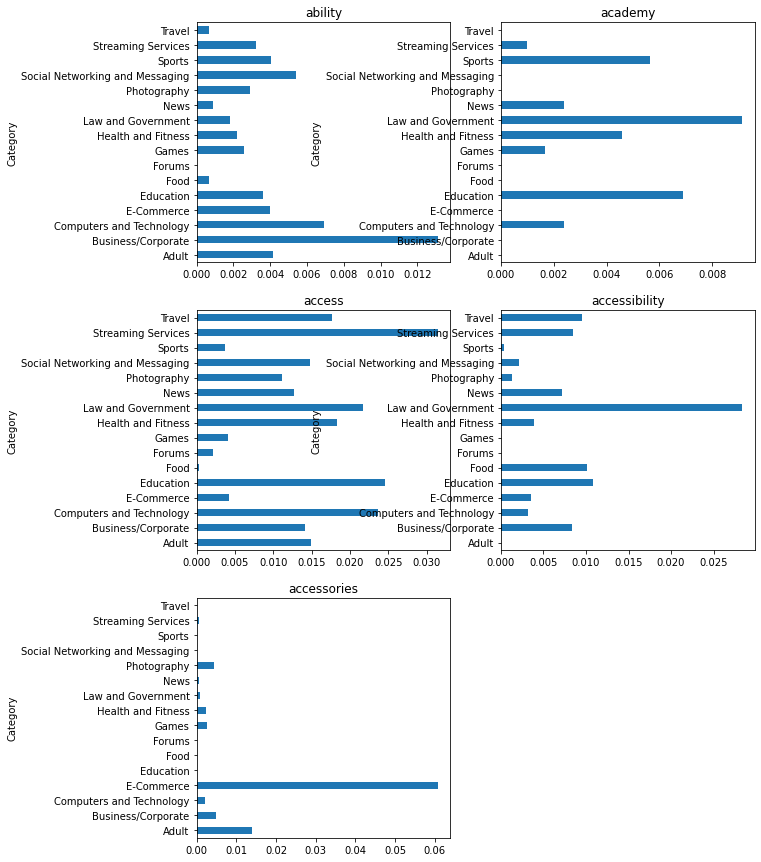

In [18]:
plt.subplots(figsize=(10,15))
for i, col in enumerate(df_f.columns[0:5]):
    plt.subplot(int(df_f.columns[0:5].shape[0]/2)+1, 2, i+1)
    df_f.groupby('Category').mean()[col].plot(kind='barh', title=col)

Observations,

- Term `accessories` is more related to `E-Commerce`. 
- Term `accessibility` is more related to `Law and Government`. 

## 5. Train-test split

In [19]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100,
                                     stratify = y)

## 6. Model Development-validation and evaluation

In [20]:
# Model development 

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [21]:
# Making prediction and evaluation

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Accuracy check

print('Train accuracy:', round(accuracy_score(y_train, y_train_pred),2))
print('Test accuracy:', round(accuracy_score(y_test, y_test_pred),2))

Train accuracy: 0.93
Test accuracy: 0.9


#### Confusion Matrix

<AxesSubplot:>

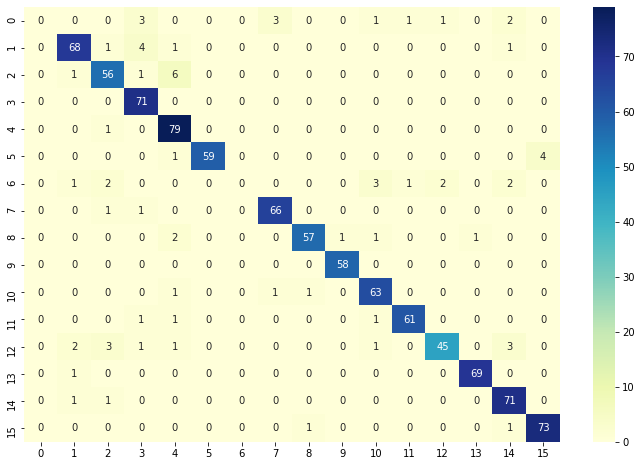

In [22]:
plt.subplots(figsize=(12,8))
sns.heatmap(confusion_matrix(y_train, y_train_pred),
           annot=True,
           cmap='YlGnBu')

<AxesSubplot:>

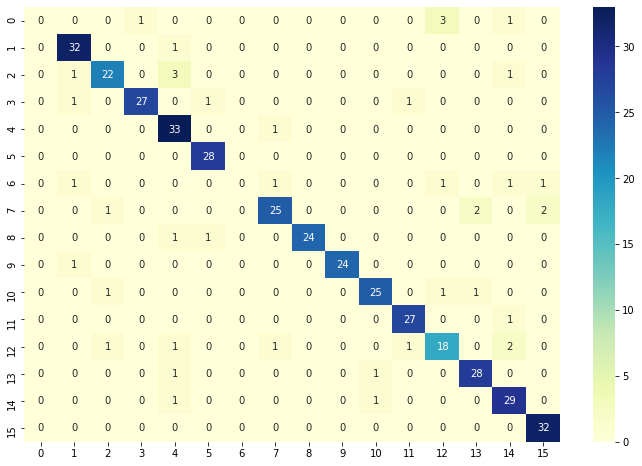

In [23]:
plt.subplots(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
           annot=True,
           cmap='YlGnBu')

Confusion matrix indicates that,

- Model is not able to estimate category 0 and 6 correctly both while training and testing. The reason can be their lesser frequency.
- Model is clearly not overfitting which is a good sign.

## 7. Conclusion/Recommendation

- NLP can be used for text processing and feature development to be used in ML model building.
- Multinomial Naive Bayes algorithm can be used to perform multi-class classification with large number of classes.
- Naive Bayes in general can handle large number of features as compared to data size quite easily.
- For future work, we can increase number of data entries for classes with less frequency and hence improve the model further.

-----------------